# Neurons (using particle system)

This tutorial demonstrates how to generate huge numbers of neurons, up to millions, with relatively little impact on the renderer's performance.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VirtualBrainLab/urchin-examples/blob/main/basics/neurons_particles.ipynb)

## Install Urchin

Urchin is a Python package stored on PyPI, the following code needs to be run the first time you use Urchin in a Python environment. 

Urchin's full documentation can be found [on our website](https://virtualbrainlab.org/urchin/installation_and_use.html).

In [ ]:
#Installing urchin
!pip install oursin -U

## Setup Urchin and open the renderer webpage 

By default Urchin opens the 3D renderer in a webpage. Make sure pop-ups are enabled, or the page won't open properly. You can also open the renderer site yourself by replacing [ID here] with the ID that is output by the call to `.setup()` at https://data.virtualbrainlab.org/Urchin/?ID=[ID here]

Note that Urchin communicates to the renderer webpage through an internet connection, we don't currently support offline use (we hope to add support in the future).

In [1]:
#Importing necessary libraries:
import oursin as urchin
urchin.setup(localhost=True)

import requests
import pandas as pd
import io

(URN) connected to server
Login sent with ID: b2ecd465, copy this ID into the renderer to connect.


## Load Allen Institute dataset

For this tutorial, we'll be using the Allen Institute's [Visual Behavior Neuropixels](https://portal.brain-map.org/explore/circuits/visual-behavior-neuropixels) dataset. This data was recorded with six probes at a time from cortical targets in visual cortex as well as a few subcortical regions. Let's start by just loading the neuron positions, as well as their raw firing rates.

We've preprocessed the data for you and saved it into a convenient CSV file.

In [2]:
file_id = '1ocRd8yXIyYWEpfcTYpLS_TA7-w4ikN8i'
download_link = f"https://drive.google.com/uc?id={file_id}"
response = requests.get(download_link)

df = pd.read_csv(io.StringIO(response.text))

In [3]:
df.head()

,Unnamed: 0,unit_id,left_right_ccf_coordinate,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,firing_rate,percentile_rank,color,size_scale
0,0,1157005856,6719.0,8453.0,3353.0,0.931674,0.262039,#cbbadc,0.046550
1,100,1157006690,6908.0,8282.0,2698.0,0.011346,0.029358,#f7f4fa,0.036577
2,200,1157006586,7494.0,7809.0,760.0,1.839420,0.367358,#b79fce,0.051917
3,300,1157006867,7481.0,7820.0,807.0,0.055077,0.081577,#ede7f3,0.038611
4,400,1157005865,6730.0,8443.0,3314.0,1.113203,0.283822,#c7b4d9,0.047613


Before doing anything with the neurons, let's just the load the root area for the CCF.

In [4]:
urchin.ccf25.load()

In [5]:
urchin.ccf25.root.set_visibility(True)
urchin.ccf25.root.set_material('transparent-lit')
urchin.ccf25.root.set_alpha(0.15)

Cool. Let's create a group of neuron objects in Urchin. To create a group of neurons, call the `urchin.neurons.create(n)` function, passing the number of neurons n as a parameter. The create function returns a list of neuron objects, which can then be passed to plural functions to set the position, color, size (etc) of all the neurons at once.

In [6]:
neurons = urchin.particles.create(len(df))

Now let's go through the dataframe, and set the positions of the neurons. When you're setting the positions of a large number of neurons like this, it's best practice to the use the "plural" functions. If you were to call `Neuron.set_position()` for each neuron in the list you would generate an unnecessary amount of communication overhead!

To use the plural `urchin.neurons.set_positions()` function, pass in the neurons list, followed by the new position for each neuron.

In [7]:
positions_list = []

for i, row in df.iterrows():
    # Note that Urchin internally uses mm, so we divide by 1000 here to get our units right
    ap = row['anterior_posterior_ccf_coordinate']/1000
    ml = row['left_right_ccf_coordinate']/1000
    dv = row['dorsal_ventral_ccf_coordinate']/1000
    positions_list.append([ap, ml, dv])

urchin.particles.set_positions(neurons, positions_list)

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


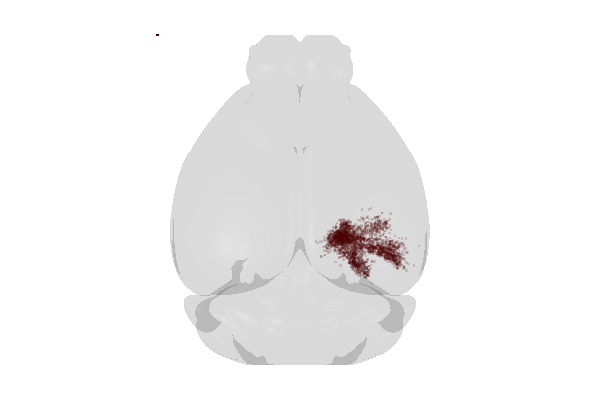

In [10]:
urchin.camera.main.set_zoom(8)
await urchin.camera.main.screenshot(size=[600,400])

Cool! That looks promising. Maybe we should add all the brain regions that the probes are going through, just to make things look good? Check out the Areas tutorial for more details on this code.

In [20]:
brain_areas = ["VISp", "VISl", "VISal", "VISpm", "VISam", "VISrl", "LGd", "LP", "CA1", "CA3", "DG"]

area_list = urchin.ccf25.get_areas(brain_areas)

urchin.ccf25.set_visibilities(area_list, True)
urchin.ccf25.set_materials(area_list, 'transparent-lit')
urchin.ccf25.set_alphas(area_list, 0.05)

{"acronym": ["VISp", "VISl", "VISal", "VISpm", "VISam", "VISrl", "LGd", "LP", "CA1", "CA3", "DG"], "side": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "visible": [true, true, true, true, true, true, true, true, true, true, true]}


Urchin can take in color input in different formats, including hex codes, RGB floats, and RGB ints. Urchin uses hex colors represented as strings by default, but you can also pass colors as lists or tuples. The followig examples are all equivalent:

`neurons[i].set_color((0,255,0))`

`neurons[i].set_color([0,255,0])`

`neurons[i].set_color((0,1.0,0))`

`neurons[i].set_color("00FF00")`

Let's set the color of all the neurons according to their firing rates. We've pre-computed the colors in the CSV file for convenience.

In [18]:
colors_list = []

for i, row in df.iterrows():
    colors_list.append(row['color'])

urchin.particles.set_colors(neurons, colors_list)

We can also set the scale of neurons in a similar way

In [19]:
sizes_list = []

for i, row in df.iterrows():
    sizes_list.append(row['size_scale'])

urchin.particles.set_sizes(neurons, sizes_list)

Now the neurons are scaled and colored by their average firing rate in the dataset, which is a pretty intuitive way of representing the data!

Note that the "plural" functions you used each have a "singular" version as well, that can be called directly from the `Neuron` objects, for example by doing: `neurons[0].set_size(3.0)`